In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [5]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

In [6]:
# Load the data
interpolated_dir = os.path.join(parent_dir, "dataset_interpolated_with_overtime")
def load_training_data(interpolated_dir, test = [2023, 2024]):
    training_data = {}
    for folder in os.listdir(interpolated_dir):
        folder_path = os.path.join(interpolated_dir, folder)
        print(f"Loading data for {folder}")
        if os.path.isdir(folder_path):
            if not(int(folder) in test):
                for file in os.listdir(folder_path):
                    if file.endswith(".csv"):
                        file_path = os.path.join(folder_path, file)
                        df = pd.read_csv(file_path)
                        for _, row in df.iloc[1:].iterrows():
                            row["relative_strength"] = df.iloc[0]["homeWinProbability"]
                            row["away_team_id"] = df.iloc[0]["away_team_id"]
                            row["home_team_id"] = df.iloc[0]["home_team_id"]
                            row["home_win"] = df.iloc[0]["home_win"]
                            if row["timestep"] not in training_data:
                                training_data[row["timestep"]] = [row] 
                            else:
                                training_data[row["timestep"]] += [row]
            else: 
                print("skipping ", folder)
    return training_data

training_data = load_training_data(interpolated_dir)

Loading data for 2022
Loading data for 2024
skipping  2024
Loading data for 2023
skipping  2023
Loading data for .DS_Store
Loading data for 2019
Loading data for 2021
Loading data for 2020
Loading data for 2018


In [7]:
# Get information about the data
for timestep in training_data:
    print(f"timestep: {timestep}, number of instances: {len(training_data[timestep])}")

timestep: 0.0, number of instances: 2027
timestep: 0.005, number of instances: 1505
timestep: 0.01, number of instances: 1361
timestep: 0.015, number of instances: 1494
timestep: 0.02, number of instances: 1407
timestep: 0.025, number of instances: 1522
timestep: 0.03, number of instances: 1493
timestep: 0.035, number of instances: 1508
timestep: 0.04, number of instances: 1523
timestep: 0.045, number of instances: 1501
timestep: 0.05, number of instances: 1522
timestep: 0.055, number of instances: 1545
timestep: 0.06, number of instances: 1539
timestep: 0.065, number of instances: 1568
timestep: 0.07, number of instances: 1549
timestep: 0.075, number of instances: 1586
timestep: 0.08, number of instances: 1579
timestep: 0.085, number of instances: 1533
timestep: 0.09, number of instances: 1590
timestep: 0.095, number of instances: 1585
timestep: 0.1, number of instances: 1612
timestep: 0.105, number of instances: 1563
timestep: 0.11, number of instances: 1600
timestep: 0.115, number o

In [8]:
features = ["home_win", "relative_strength", "score_difference", "type.id", "home_has_possession", "end.down", "end.yardsToEndzone", "end.distance", "field_position_shift", "home_timeouts_left", "away_timeouts_left"]
# for timestep in training_data.keys():
#     # Find rows that have NaN values for my array of features
#     rows = training_data[timestep]
#     # Get all rows such that one of the features is NaN
#     rows_with_nan = [row for row in rows if any(np.isnan(row[feature]) for feature in features)]
#     # Print row with NaN values + timestep
#     if len(rows_with_nan) > 0:
#         print("Timestep:", timestep)
#         for row in rows_with_nan:
#             print(row)

In [9]:
for timestep in training_data.keys():
    rows = training_data[timestep]
    
    # Replace NaN values with 0
    for row in rows:
        for feature in features:
            if np.isnan(row[feature]):
                row[feature] = 0

In [ ]:
# Feature Selection
def feature_selection(data, features, replace_nan_val = 0):
    # Given the features of the data, return data such that each row is an array of the values of the features
    # The data is a dictionary where the key is the timestep and the value is a list of rows
    feature_data = {}
    for timestep in data:
        feature_data[timestep] = []
        for row in data[timestep]:
            new_row = [float(row[feature]) for feature in features]
            # First check if the row has any NaN values
            new_row = [val if not np.isnan(val) else replace_nan_val for val in new_row] 
            feature_data[timestep].append(new_row)
    return feature_data

features_data = feature_selection(training_data, features)

In [14]:
# Setup model for each timestep
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# create an array of logistic regression models
models = {}
def setup_models(features_data):
    for timestep in features_data:
        X = np.array(features_data[timestep])[:,1:]
        y = np.array(features_data[timestep])[:,0]
        model = LogisticRegression(max_iter=1000)
        print("Training for timestep", timestep)
        model.fit(X, y)
        models[timestep] = model


setup_models(features_data)


Training for timestep 0.0
Training for timestep 0.005
Training for timestep 0.01
Training for timestep 0.015
Training for timestep 0.02
Training for timestep 0.025
Training for timestep 0.03
Training for timestep 0.035
Training for timestep 0.04
Training for timestep 0.045
Training for timestep 0.05
Training for timestep 0.055
Training for timestep 0.06
Training for timestep 0.065
Training for timestep 0.07
Training for timestep 0.075
Training for timestep 0.08
Training for timestep 0.085
Training for timestep 0.09
Training for timestep 0.095
Training for timestep 0.1
Training for timestep 0.105
Training for timestep 0.11
Training for timestep 0.115
Training for timestep 0.12
Training for timestep 0.125
Training for timestep 0.13
Training for timestep 0.135
Training for timestep 0.14
Training for timestep 0.145
Training for timestep 0.15
Training for timestep 0.155
Training for timestep 0.16
Training for timestep 0.165
Training for timestep 0.17
Training for timestep 0.175
Training for

In [15]:
def load_test_data(interpolated_dir, test = [2023, 2024]):
    test_folders = {}
    for folder in os.listdir(interpolated_dir):
        folder_path = os.path.join(interpolated_dir, folder)
        print(f"Loading data for {folder}")
        if os.path.isdir(folder_path):
            if int(folder) in test:
                test_data = {}
                for file in os.listdir(folder_path):
                    if file.endswith(".csv"):
                        seen_timesteps = set()
                        file_path = os.path.join(folder_path, file)
                        df = pd.read_csv(file_path)
                        for _, row in df.iloc[1:].iterrows():
                            row["relative_strength"] = df.iloc[0]["homeWinProbability"]
                            row["away_team_id"] = df.iloc[0]["away_team_id"]
                            row["home_team_id"] = df.iloc[0]["home_team_id"]
                            row["home_win"] = df.iloc[0]["home_win"]
                            if file not in test_data and row["timestep"] not in seen_timesteps:
                                seen_timesteps.add(row["timestep"])
                                test_data[file] = [row] 
                            elif row["timestep"] not in seen_timesteps:
                                seen_timesteps.add(row["timestep"]) 
                                test_data[file] += [row]
                test_folders[folder] = test_data
    return test_folders
test_folders = load_test_data(interpolated_dir)
for timestep in test_folders:
    print(f"timestep: {timestep}, number of instances: {len(test_folders[timestep])}")
print(test_folders.keys())

Loading data for 2022
Loading data for 2024
Loading data for 2023
Loading data for .DS_Store
Loading data for 2019
Loading data for 2021
Loading data for 2020
Loading data for 2018
timestep: 2024, number of instances: 272
timestep: 2023, number of instances: 272
dict_keys(['2024', '2023'])


In [16]:
def test_feature_selection(data, features, replace_nan_val = 0):
    # Given the features of the data, return data such that each row is an array of the values of the features
    # The data is a dictionary where the key is the timestep and the value is a list of rows
    feature_data = {}
    for file in data:
        feature_data[file] = []
        for row in data[file]:
            new_row = [[float(row[feature]) for feature in features]]
            # First check if the row has any NaN values
            new_row = [[val if not np.isnan(val) else replace_nan_val for val in new_row[0]]] 
            feature_data[file] += new_row
    return feature_data
features_test_data = {key: test_feature_selection(test_data, features) for key, test_data in zip(test_folders.keys(), test_folders.values())}

In [17]:
X_tests = [features_test_data[year] for year in features_test_data]
merged = {}
for d in X_tests:
    merged.update(d)
X_tests = merged
new_X_tests = {}
print(len(X_tests))
for file in X_tests:
   timestep = 0
   for i in range(len(X_tests[file])):
        if timestep not in new_X_tests:
           new_X_tests[timestep] = [X_tests[file][i]]
        else:
            new_X_tests[timestep] += [X_tests[file][i]]
        timestep += 0.005
X_tests = new_X_tests
# len(X_tests[0.1])
X_tests.keys()

544


dict_keys([0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.030000000000000002, 0.035, 0.04, 0.045, 0.049999999999999996, 0.05499999999999999, 0.05999999999999999, 0.06499999999999999, 0.06999999999999999, 0.075, 0.08, 0.085, 0.09000000000000001, 0.09500000000000001, 0.10000000000000002, 0.10500000000000002, 0.11000000000000003, 0.11500000000000003, 0.12000000000000004, 0.12500000000000003, 0.13000000000000003, 0.13500000000000004, 0.14000000000000004, 0.14500000000000005, 0.15000000000000005, 0.15500000000000005, 0.16000000000000006, 0.16500000000000006, 0.17000000000000007, 0.17500000000000007, 0.18000000000000008, 0.18500000000000008, 0.19000000000000009, 0.1950000000000001, 0.2000000000000001, 0.2050000000000001, 0.2100000000000001, 0.2150000000000001, 0.2200000000000001, 0.22500000000000012, 0.23000000000000012, 0.23500000000000013, 0.24000000000000013, 0.24500000000000013, 0.2500000000000001, 0.2550000000000001, 0.2600000000000001, 0.2650000000000001, 0.27000000000000013, 0.2750000000000001

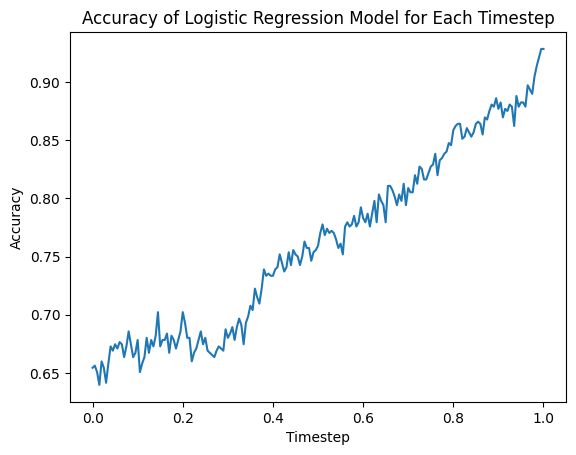

In [18]:
# Test accuracy of model for each timestep on test data and plot
accuracies = []
timesteps = []

for timestep, i in zip(models, X_tests.keys()):
    model = models[timestep]
    # MODIFY THIS TO GET TEST DATA
    X_test = np.array(X_tests[i])
    y_test = X_test[:,0]
    X_test = X_test[:,1:]
    accuracy = model.score(X_test, y_test)
    accuracies.append(accuracy)
    timesteps.append(timestep)

plt.plot(timesteps, accuracies)
plt.xlabel("Timestep")
plt.ylabel("Accuracy")
plt.title("Accuracy of Logistic Regression Model for Each Timestep")
plt.show()

In [19]:
for folder in features_test_data:
    print(folder)
    test_data = features_test_data[folder]
    for file in test_data:
        for i, timestep in zip(range(len(models)), models):
            model = models[timestep]
            X_test = np.array(test_data[file][i])[1:].reshape(1, -1)
            y_test = np.array(test_data[file][i])[0].reshape(1, -1)
            pred = model.predict_proba(X_test)
            print(f"Prediction for timestep {timestep} in {file}: {pred}")
        

2024
Prediction for timestep 0.0 in game_401671629.csv: [[0.49079294 0.50920706]]
Prediction for timestep 0.005 in game_401671629.csv: [[0.4378144 0.5621856]]
Prediction for timestep 0.01 in game_401671629.csv: [[0.50566849 0.49433151]]
Prediction for timestep 0.015 in game_401671629.csv: [[0.49187851 0.50812149]]
Prediction for timestep 0.02 in game_401671629.csv: [[0.54197828 0.45802172]]
Prediction for timestep 0.025 in game_401671629.csv: [[0.44661166 0.55338834]]
Prediction for timestep 0.03 in game_401671629.csv: [[0.42837127 0.57162873]]
Prediction for timestep 0.035 in game_401671629.csv: [[0.48129063 0.51870937]]
Prediction for timestep 0.04 in game_401671629.csv: [[0.40952876 0.59047124]]
Prediction for timestep 0.045 in game_401671629.csv: [[0.44545633 0.55454367]]
Prediction for timestep 0.05 in game_401671629.csv: [[0.45747787 0.54252213]]
Prediction for timestep 0.055 in game_401671629.csv: [[0.47282923 0.52717077]]
Prediction for timestep 0.06 in game_401671629.csv: [[0.

In [20]:
model = models[1.0]
model.predict_proba([[0.7006, 31.0, 30.0, 0.0, 4.0, 5.0, 22.0, 4.0, 5.0, 22.0]])

array([[1.33071332e-12, 1.00000000e+00]])

In [ ]:
# Save the model
import pickle
filename = 'logistic_regression_model.sav'
pickle.dump(models, open(filename, 'wb'))

In [21]:
# Write the predictions to csv file
for folder in features_test_data:
    print(folder)
    test_data = features_test_data[folder]
    for file in test_data:
        df = pd.read_csv(os.path.join(interpolated_dir, folder, file))
        print(file)
        # print(len(test_data[file]))
        rows = df.iloc[1:].iterrows()
        index, row = next(rows)
        for i, timestep in zip(range(len(models)), models):
            model = models[timestep]
            # print(i)
            X_test = np.array(test_data[file][i])[1:].reshape(1, -1)
            pred = model.predict_proba(X_test)
            # Open the file and add column called phat_b
            try:
                while round(row["timestep"], 3) == round(timestep, 3):
                    df.at[index, "phat_b_LR"] = pred[0][1]
                    index, row = next(rows)
            except StopIteration:
                pass
        df.to_csv(os.path.join(interpolated_dir, folder, file), index=False)
        print(f"Finished writing to {file}")

2024
game_401671629.csv
Finished writing to game_401671629.csv
game_401671601.csv
Finished writing to game_401671601.csv
game_401671826.csv
Finished writing to game_401671826.csv
game_401671832.csv
Finished writing to game_401671832.csv
game_401671749.csv
Finished writing to game_401671749.csv
game_401671775.csv
Finished writing to game_401671775.csv
game_401671761.csv
Finished writing to game_401671761.csv
game_401671760.csv
Finished writing to game_401671760.csv
game_401671774.csv
Finished writing to game_401671774.csv
game_401671748.csv
Finished writing to game_401671748.csv
game_401671833.csv
Finished writing to game_401671833.csv
game_401671827.csv
Finished writing to game_401671827.csv
game_401671600.csv
Finished writing to game_401671600.csv
game_401671628.csv
Finished writing to game_401671628.csv
game_401671616.csv
Finished writing to game_401671616.csv
game_401671831.csv
Finished writing to game_401671831.csv
game_401671825.csv
Finished writing to game_401671825.csv
game_4016

# For Debugging Purposes

In [120]:
for folder in os.listdir(interpolated_dir):
    if not os.path.isdir(os.path.join(interpolated_dir, folder)):
        continue
    print(folder)
    for file in os.listdir(os.path.join(interpolated_dir, folder)):
        if file.endswith(".csv"):
            data = pd.read_csv(os.path.join(interpolated_dir, folder, file))
            # check if data.iloc[1]["homeScore"] is NaN
            if pd.isna(data.iloc[1]["homeScore"]) or pd.isna(data.iloc[1]["awayScore"]):
                print(file)

2022
2023
2019
2021
2020
2018
